*Antonio Coín Castro*     

# Bayesian Functional Linear Regression

In [125]:
# Libraries
from matplotlib import pyplot as plt
import arviz as az
import numpy as np
import pandas as pd
import pickle
import scipy
from multiprocessing import Pool
import utils

In [126]:
# Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We consider the model

$$
Y_i = \mu + \Psi^{-1}_{X_i}(\alpha) + \varepsilon_i,
$$

i.e.,

$$
Y_i \sim \mathcal N\left(\mu + \sum_{j=1}^p \beta_jX_i(t_j), \ \sigma^2\right).
$$

Let us impose a discrete prior on $p \in \{1, \dots, 6\}$ given by the following probabilities:

\begin{align*}
\pi(p=1) &= 0.05,\\
\pi(p=2) &= 0.1,\\
\pi(p=3) &= 0.3,\\
\pi(p=4) &= 0.3,\\
\pi(p=5) &= 0.15,\\
\pi(p=6) &= 0.1.
\end{align*}

The prior distributions chosen for the remaining parameters are:

\begin{align*}
  \pi(\mu, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N(b_0, g\sigma^2(\mathcal X_\tau' \mathcal X_\tau + \eta I)^{-1}),
\end{align*}

Writing the parameter vector as $\theta = (p, \beta, \tau, \mu, \sigma^2)$, the joint posterior probability is:

$$
\pi(p, \beta, \tau, \mu, \sigma^2\mid Y) \propto \pi(p)\frac{|G_\tau|^{1/2}}{\sigma^{p+n+2}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \mu\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(p, \beta, \tau, \mu, \sigma^2\mid Y) \propto \log \pi(p) + \frac{1}{2}\log |G_\tau| - (p+n+2)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\mu\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\mu, \log\sigma) \propto 1.
$$

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim BM$, a response variable given by a "simple" RKHS function with $p=2$, a value of $\mu=5$ and a variance of $\sigma^2=1$:

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 1\big).
$$

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

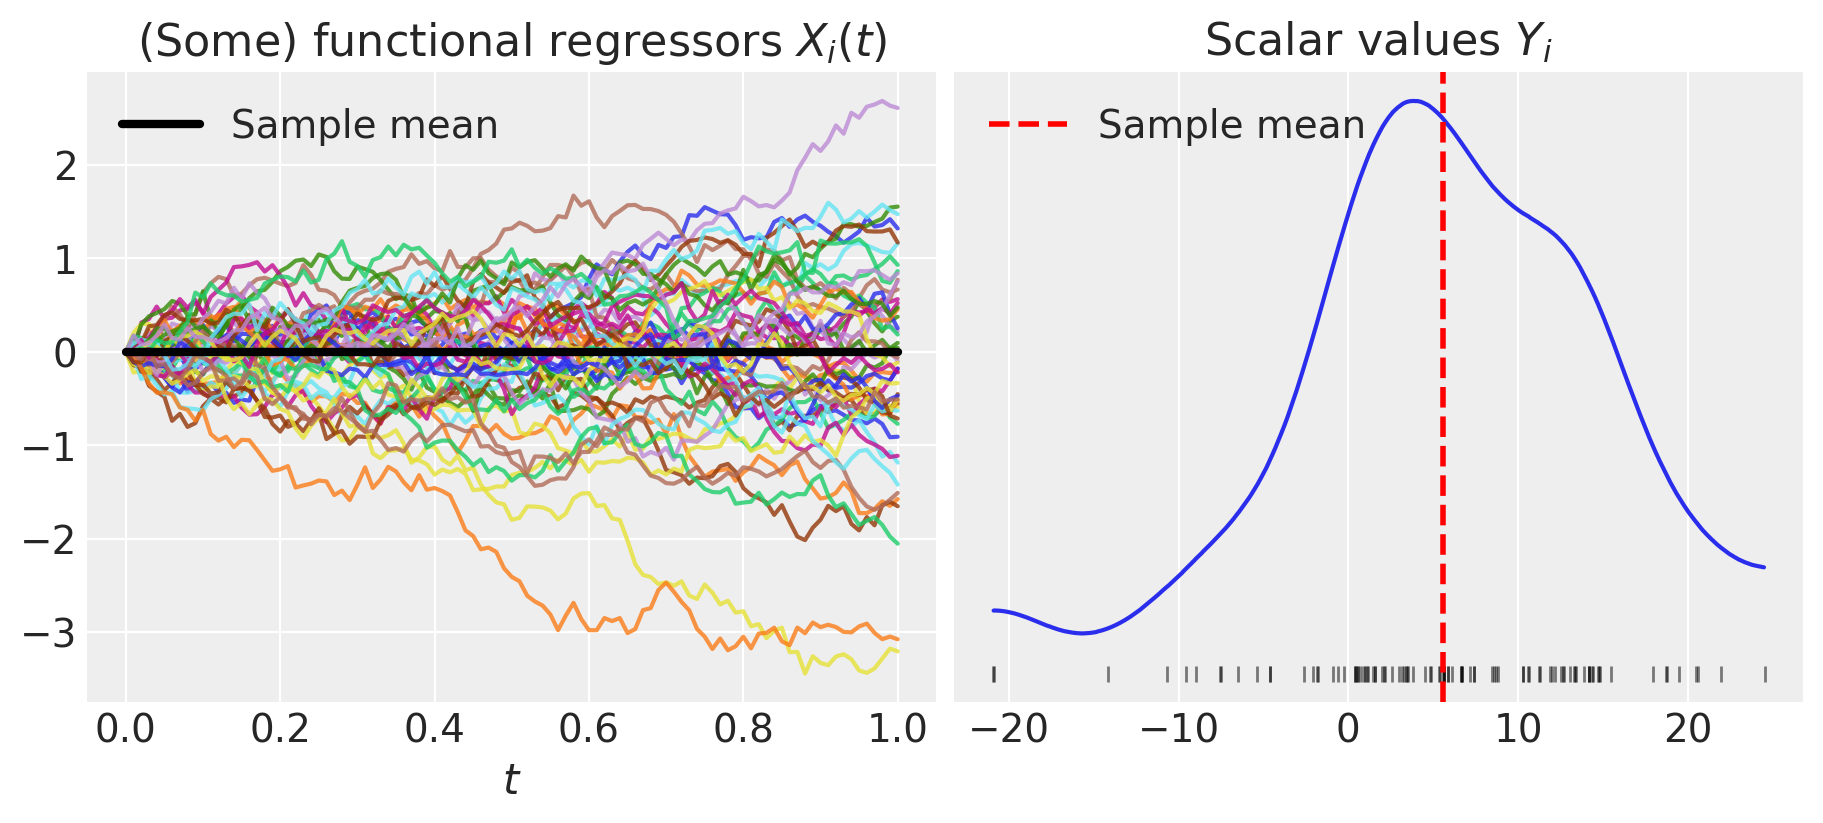

In [127]:
def brownian_kernel(s, t, sigma=1.0):
    return sigma*np.minimum(s, t)


n, N = 100, 100
grid = np.linspace(0., 1., N + 1)
beta_true = np.array([-5., 10.])
tau_true = np.array([0.1, 0.8])
mu_true = 5
sigma2_true = 1.0
p_true = len(beta_true)
theta_names = ["p", "beta", "tau", "mu", "sigma2"]

X, Y = utils.generate_gp_dataset(
    rng, grid, brownian_kernel, n,
    beta_true, tau_true, mu_true, sigma2_true
)

# Standardize data
X_m = X.mean(axis=0)
X = X - X_m

utils.plot_dataset(X, Y, grid)

## Common model hyperparameters

In [128]:
p_mass = {1: 0.05, 2: 0.1, 3: 0.3, 4: 0.3, 5: 0.15, 6: 0.1}
max_p = len(p_mass)
g = 5
eta = 0.1
sd_p_init = 1
sd_beta_init = 5
sd_mu_init = 10*np.abs(Y.mean())  # Grollemund et al (?)
sd_log_sigma_init = 1

# Labels
labels = [r"$p$"]
for i in range(max_p):
    labels.append(fr"$\beta_{i + 1}$")
for i in range(max_p):
    labels.append(fr"$t_{i + 1}$")
labels.append(r"$\mu$")
labels.append(r"$\sigma^2$")

# Dimension of parameter vector
theta_ndim = len(labels)

def initial_guess_random(max_p, sd_beta, sd_mu, sd_log_sigma, n_walkers=1):
    p_init = rng.integers(1, max_p, size=(n_walkers, 1), endpoint=True)
    beta_init = sd_beta*rng.standard_normal(size=(n_walkers, max_p))
    tau_init = rng.uniform(size=(n_walkers, max_p))
    mu_init = sd_mu*rng.standard_normal(size=(n_walkers, 1))
    log_sigma_init = sd_log_sigma*rng.standard_normal(size=(n_walkers, 1))
    
    # Discard coefficients beta[i] with i > p_init
    for i in range(n_walkers):
        p_i = int(p_init[i, 0])
        beta_init[i, p_i:] = 0

    init = np.hstack((
        p_init,
        beta_init,
        tau_init,
        mu_init,
        log_sigma_init
    ))

    return init if n_walkers > 1 else init[0]


def intial_guess_around_value(
        value, max_p, sd_p=1, sd_beta=1, sd_tau=0.1,
        sd_mu=1, sd_log_sigma=0.5, n_walkers=1):
    assert(len(value) == 2*max_p + 3)
    p_jitter = sd_p*rng.standard_normal(size=(n_walkers, 1))
    beta_jitter = sd_beta*rng.standard_normal(size=(n_walkers, max_p))
    tau_jitter = sd_tau*rng.standard_normal(size=(n_walkers, max_p))
    mu_jitter = sd_mu*rng.standard_normal(size=(n_walkers, 1))
    log_sigma_jitter = sd_log_sigma*rng.standard_normal(size=(n_walkers, 1))

    jitter = np.hstack((
        p_jitter,
        beta_jitter,
        tau_jitter,
        mu_jitter,
        log_sigma_jitter
    ))

    init_jitter = value[np.newaxis, :] + jitter
    
     # Restrict p to {1, ..., max_p}
    init_jitter[:, 0] = np.rint(init_jitter[:, 0])
    init_jitter[:, 0] = np.clip(init_jitter[:, 0], 1, max_p)
    
    # Restrict tau to [0, 1]
    init_jitter[:, max_p + 1:2*max_p + 1] = \
        np.clip(init_jitter[:, max_p + 1:2*max_p + 1], 0.0, 1.0)
    
    # Discard coefficients beta[i] with i > p_init
    for i in range(n_walkers):
        p_i = int(init_jitter[i, 0])
        init_jitter[i, p_i + 1:max_p + 1] = 0

    return init_jitter if n_walkers > 1 else init_jitter[0]

## Maximum Likelihood Estimator

In [129]:
def neg_ll(theta, X, Y, grid, max_p):
    assert(len(theta) == 2*max_p + 3)
    
    n, _ = X.shape
    p = int(np.rint(theta[0]))
    beta = theta[1:max_p + 1]
    tau = theta[max_p + 1:2*max_p + 1]
    mus = theta[-2]*np.ones(n)
    log_sigma = theta[-1]
    sigma = np.exp(log_sigma)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    
    X_tau_p = X[:, :p]
    beta_p = beta[:p]

    return -(-n*log_sigma
             - np.linalg.norm(Y - mus - X_tau_p@beta_p)**2/(2*sigma**2))

In [167]:
# We artificially constrain the variance to a sensible value of sigma <= 20
bounds = ([(1, max_p)] + [(None, None)]*max_p + [(0.0, 1.0)]*max_p
          + [(None, None)] + [(None, 3.0)])

theta_init = initial_guess_random(max_p, sd_beta_init,
                                  sd_mu_init, sd_log_sigma_init)

mle = scipy.optimize.minimize(
    neg_ll,
    x0=theta_init,
    args=(X, Y, grid, max_p),
    bounds=bounds,
    method='Nelder-Mead'
)

mle.x[0] = np.rint(mle.x[0])
mle_theta = mle.x
mle_orig = np.copy(mle_theta)
mle_orig[-1] = np.exp(mle_theta[-1])**2  # Transform back to sigma^2

pd.DataFrame(zip(labels, mle_orig),
             columns=["", "MLE"]).style.hide_index()

## The Ensemble Sampler and the *emcee* library

In [7]:
import emcee

### Model

We only need to provide the sampler with the logarithm of the posterior distribution. For clarity we split up its computation in log-prior and log-likelihood, although for a more efficient implementation it should all be in one function. 

In [8]:
def log_prior_and_sample(theta):
    """Global parameters (for efficient parallelization): X, b0, g, eta, grid"""
    n = X.shape[0]
    beta = theta[:p_hat]
    tau = theta[p_hat:2*p_hat]
    mu = theta[-2]
    log_sigma = theta[-1]

    # Transform variables
    b = beta - b0
    sigma = np.exp(log_sigma)

    # Impose constraints on parameters
    if (tau < 0.0).any() or (tau > 1.0).any():
        return -np.inf, np.full(n, -np.inf)

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta * \
        np.max(np.linalg.eigvalsh(G_tau))*np.identity(p_hat)

    # Compute log-prior
    log_prior = (0.5*utils.logdet(G_tau_reg)
                 - (p_hat + 2)*log_sigma
                 - b.T@G_tau_reg@b/(2*g*sigma**2))

    # Compute posterior predictive sample
    posterior_predictive_sample = mu + X_tau@beta + \
        sigma*rng.standard_normal(size=n)

    return log_prior, posterior_predictive_sample


def log_likelihood(theta, Y):
    """Global parameters (for efficient parallelization): X, grid"""
    return -neg_ll(theta, X, Y, grid, p_hat)


def log_posterior(theta, Y):
    lp, pps = log_prior_and_sample(theta)
    ll = log_likelihood(theta, Y)
    lpos = lp + ll

    return lpos, pps

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [9]:
n_walkers = 100
n_iter_initial = 500
n_iter = 1000

# Start every walker in a (random) neighbourhood around the MLE
p0 = intial_guess_around_value(mle_theta, p_hat, n_walkers=n_walkers)
b0 = mle_theta[:p_hat]  # <-- Change if needed

In [10]:
with Pool(N_CORES) as pool:
    print(
        f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")
    
    sampler = emcee.EnsembleSampler(
        n_walkers, theta_ndim, log_posterior, pool=pool, args=(Y,))
    
    print("Tuning phase...")
    state = sampler.run_mcmc(
        p0, n_iter_initial, progress='notebook',
        store=False)  
    sampler.reset()
    
    print("MCMC sampling...")
    sampler.run_mcmc(state, n_iter, progress='notebook')

-- Running affine-invariant ensemble sampler with 4 cores --
Tuning phase...


  0%|          | 0/500 [00:00<?, ?it/s]

MCMC sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]

### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [11]:
# Analyze autocorrelation and perform burn-in and thinning
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
burn = int(3*max_autocorr)
thin = 1

# Get trace of samples
trace = np.copy(sampler.get_chain(discard=burn, thin=thin))
trace[:, :, -1] = np.exp(trace[:, :, -1])**2  # Recover sigma^2
trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

# Get InferenceData object
idata_emcee = az.from_emcee(
    sampler,
    var_names=labels,
    blob_names=["y_obs"],
    arg_names=["y_obs"],
    blob_groups=["posterior_predictive"])
idata_emcee = idata_emcee.sel(draw=slice(burn, None, thin))
idata_emcee["posterior"][labels[-1]] = \
    np.exp(idata_emcee["posterior"][labels[-1]])**2  # Recover sigma^2

# Sampler statistics
autocorr_thin = sampler.get_autocorr_time(discard=burn, thin=thin, quiet=True)
print(
    f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")
pd.DataFrame(
    zip(labels, autocorr_thin, len(trace_flat)/autocorr_thin),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [67.753 68.929 65.471 72.343 71.291 69.494 68.132 65.602]
The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 16;
tau: [56.356 57.46  58.926 59.788 57.705 59.564 60.745 56.192]


Mean acceptance fraction: 31.376%


In [12]:
utils.summary(idata_emcee, labels, kind="stats")

mean     sd  hdi_3%  hdi_97%   mode
$\beta_1$   9.849  0.107   9.644   10.051  9.859
$\beta_2$  -4.098  0.475  -4.928   -3.199 -4.216
$\beta_3$  -1.011  0.661  -2.222    0.268 -1.062
$t_1$       0.800  0.003   0.795    0.804  0.800
$t_2$       0.099  0.007   0.095    0.105  0.096
$t_3$       0.040  0.033   0.000    0.101  0.000
$\mu$       5.597  0.101   5.413    5.788  5.593
$\sigma^2$  1.040  0.154   0.764    1.324  1.005

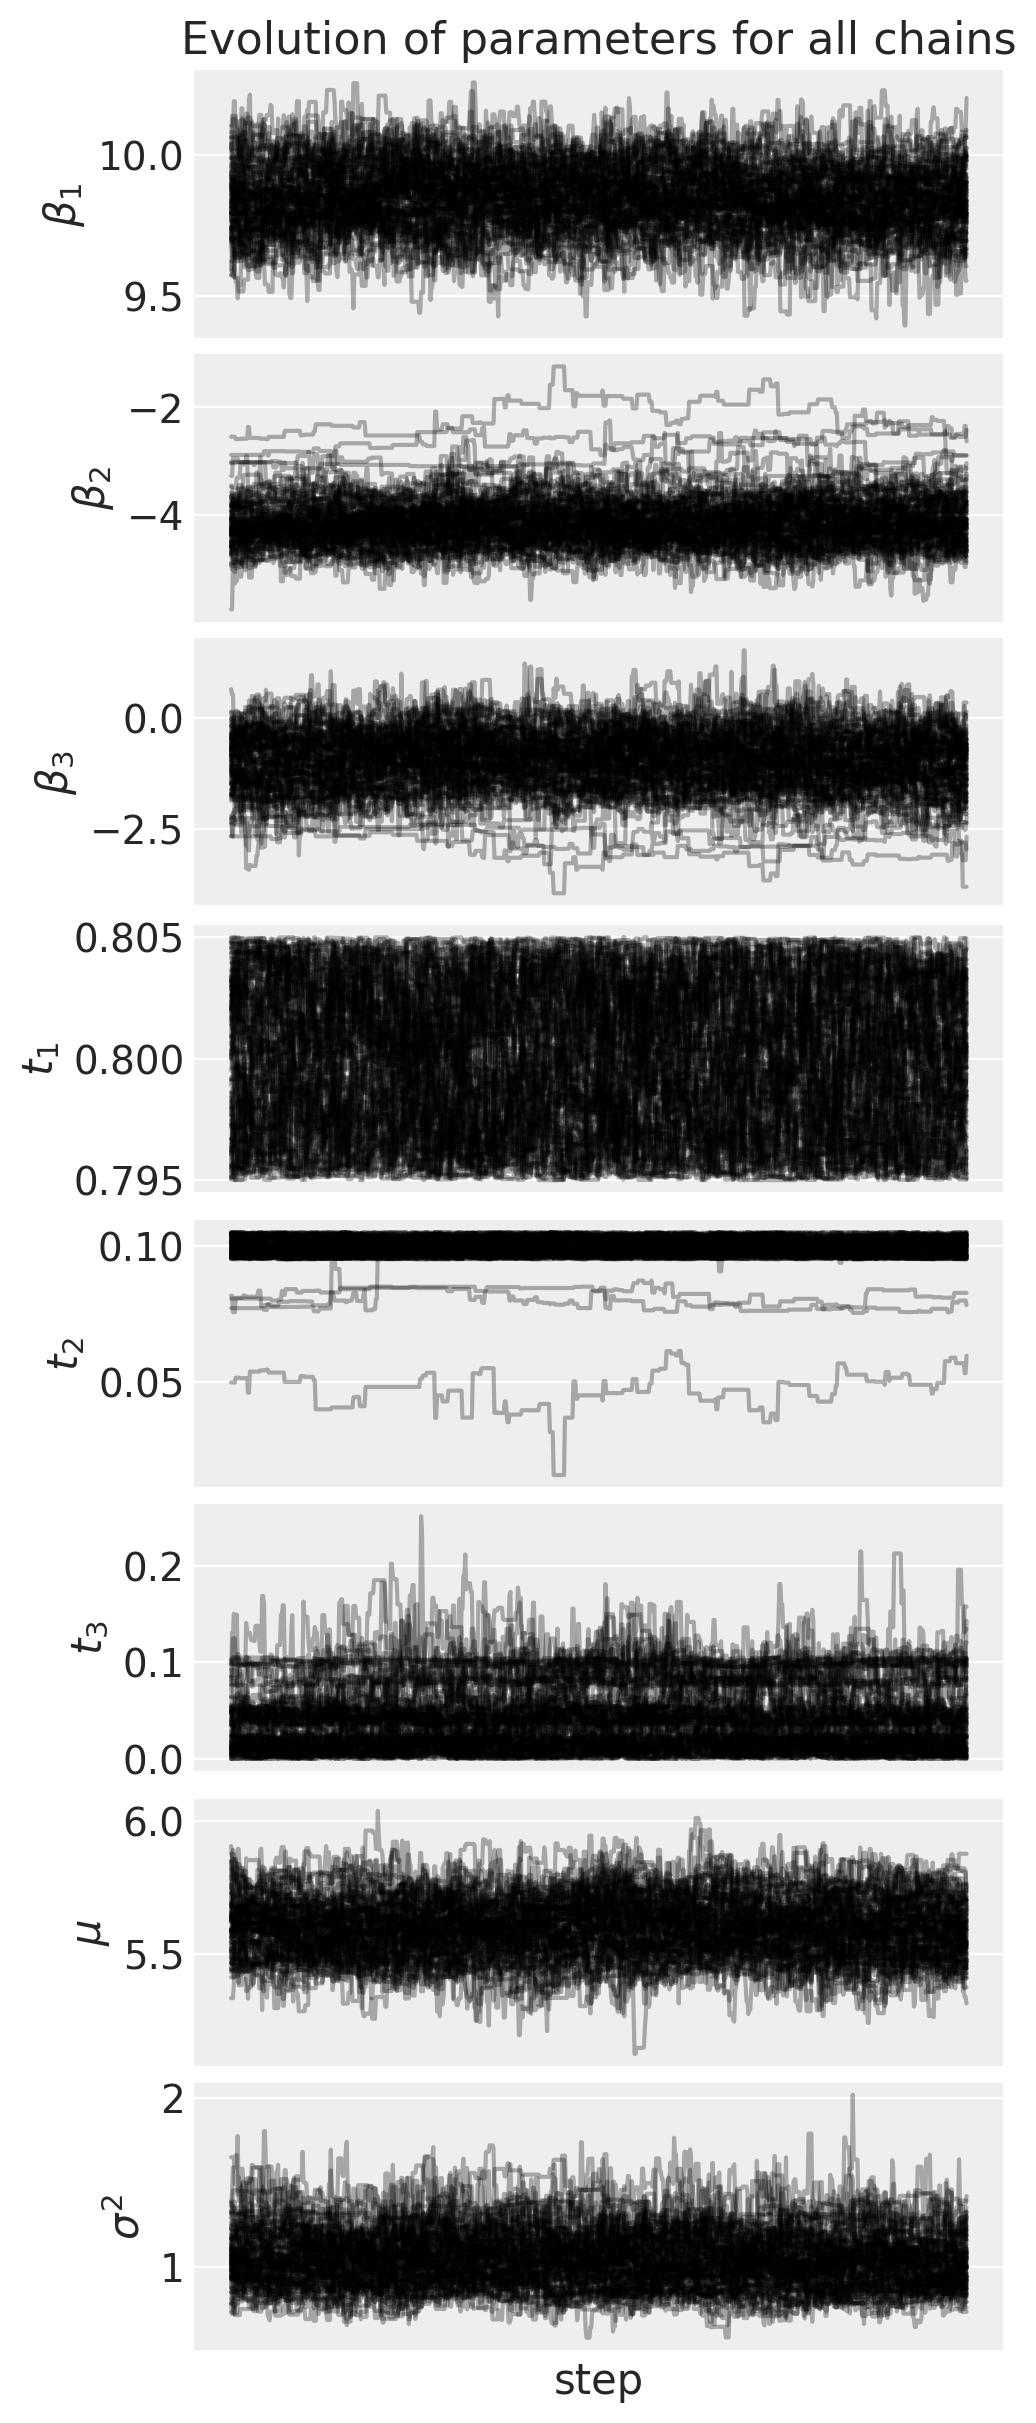

In [13]:
utils.plot_evolution(trace, labels)  # az.plot_trace(idata_emcee)

Marginal posterior distributions:


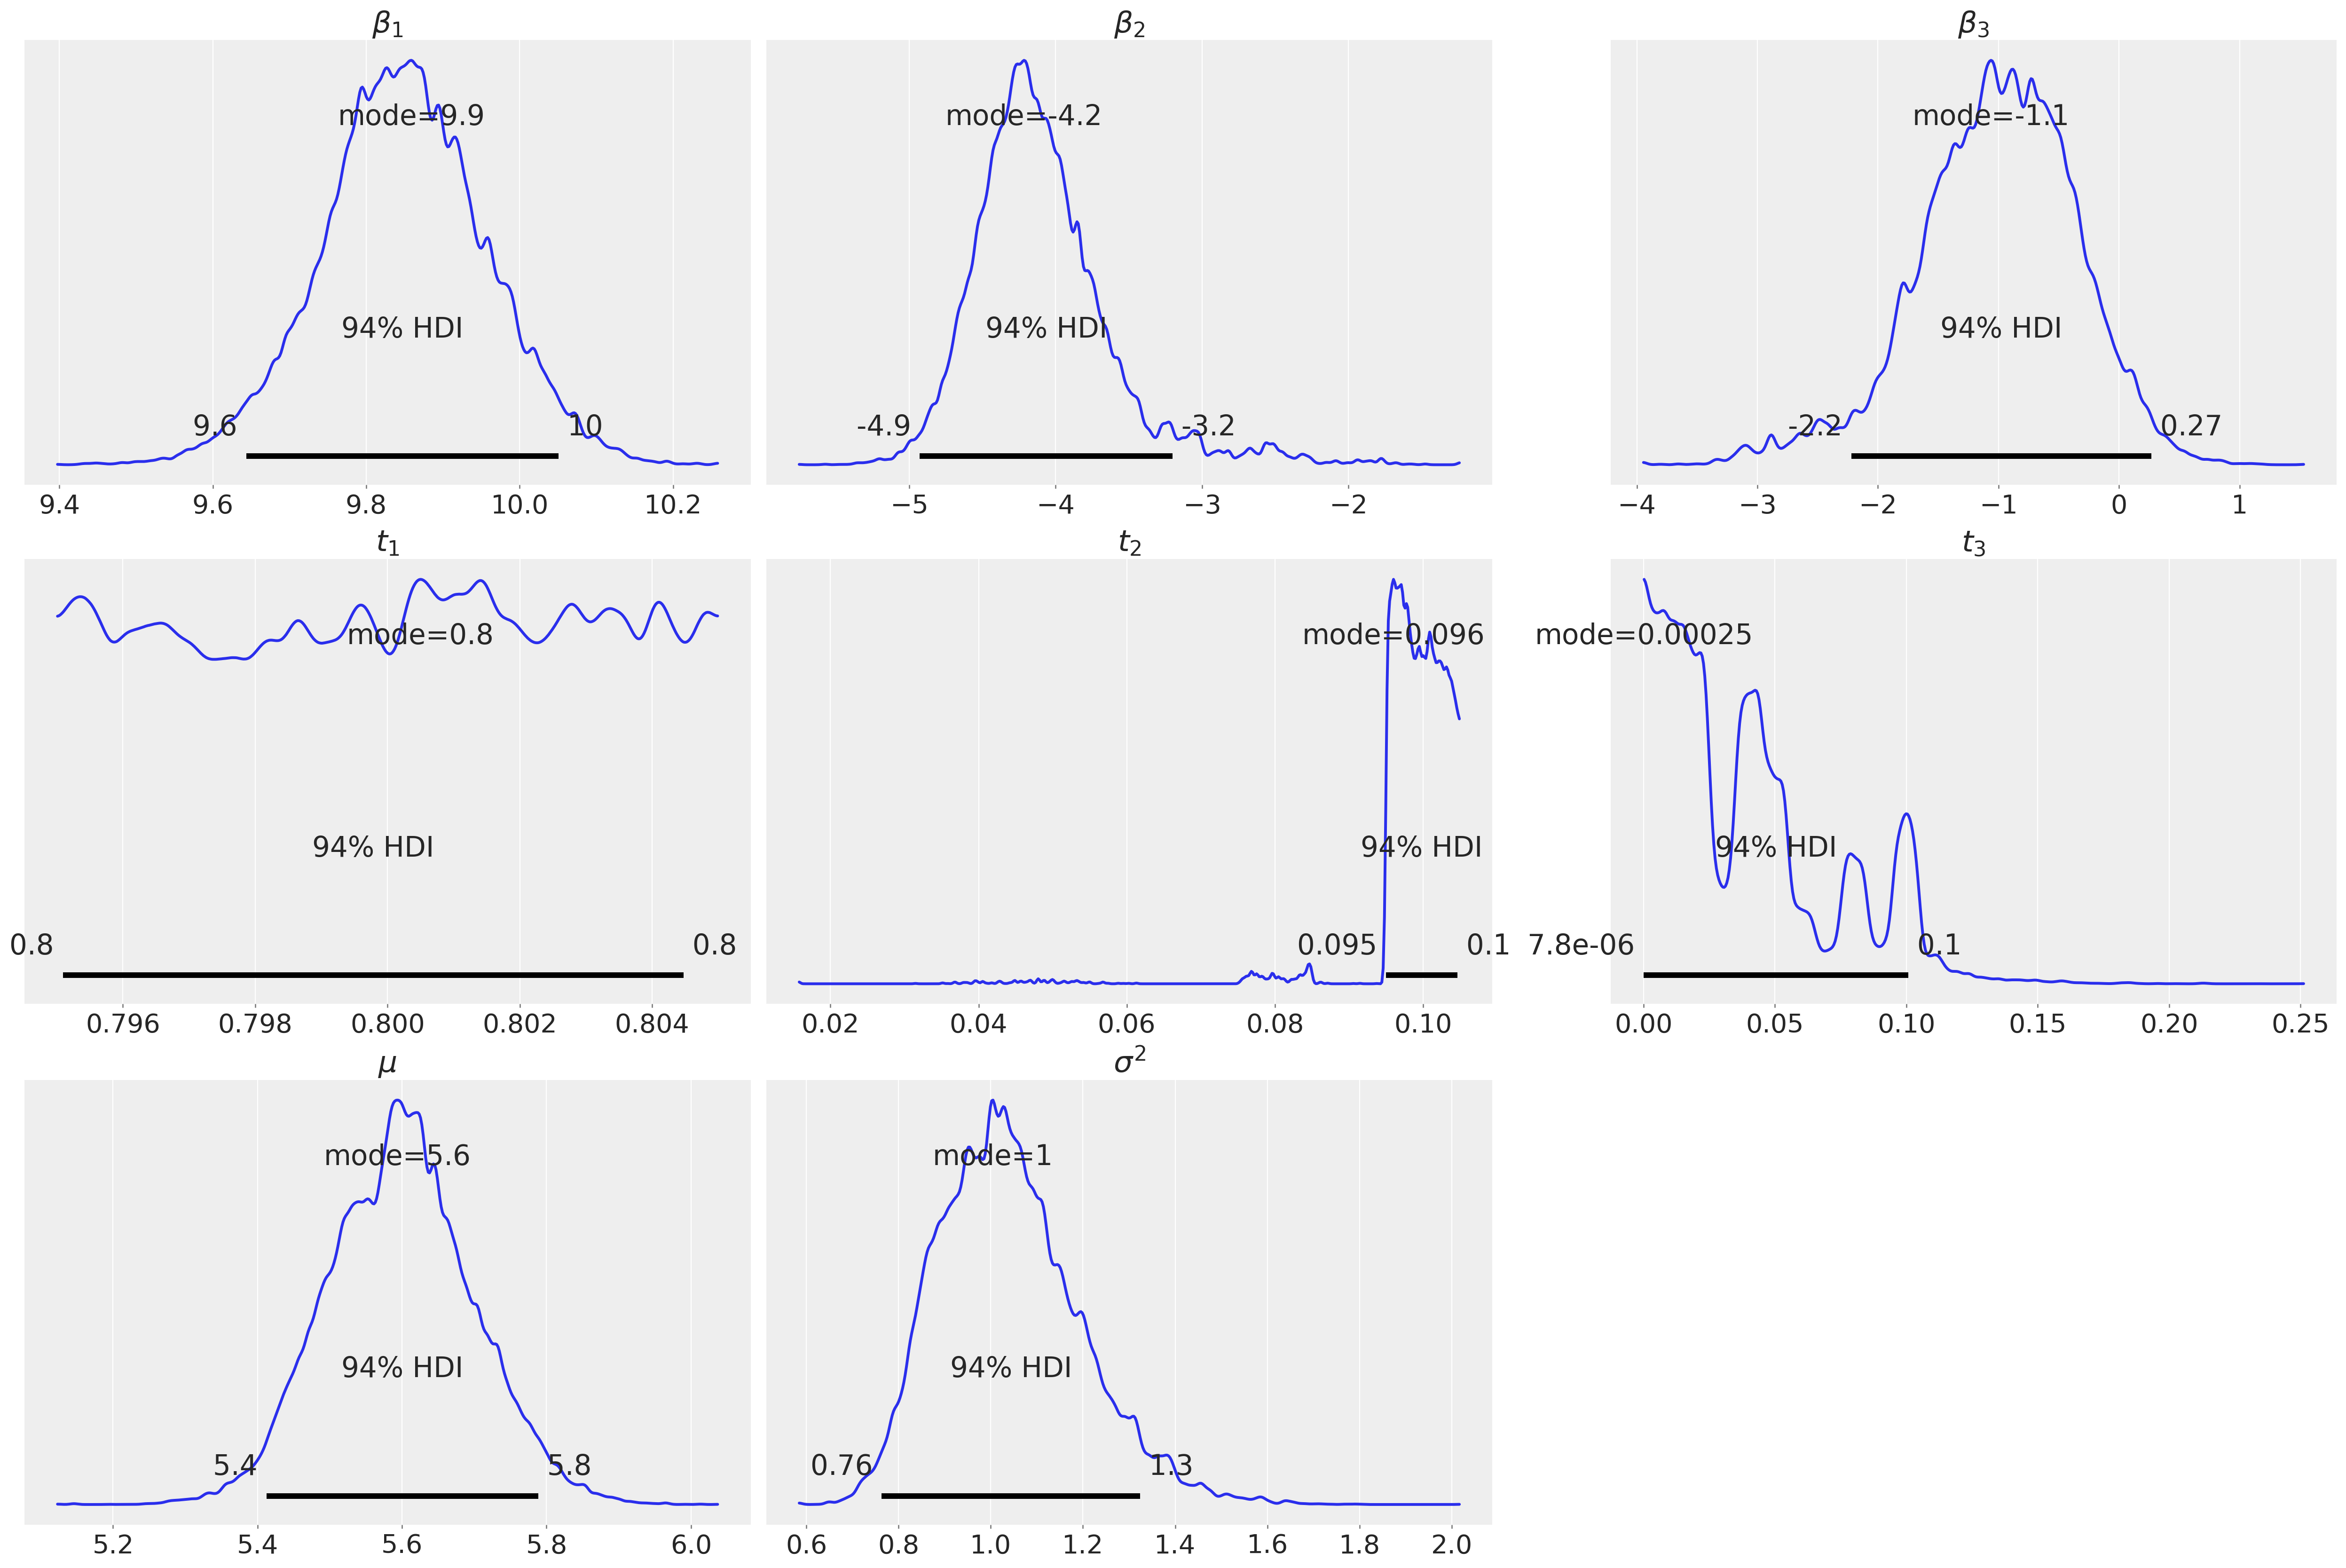

In [14]:
az.plot_posterior(idata_emcee, var_names=labels, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20)
print("Marginal posterior distributions:")

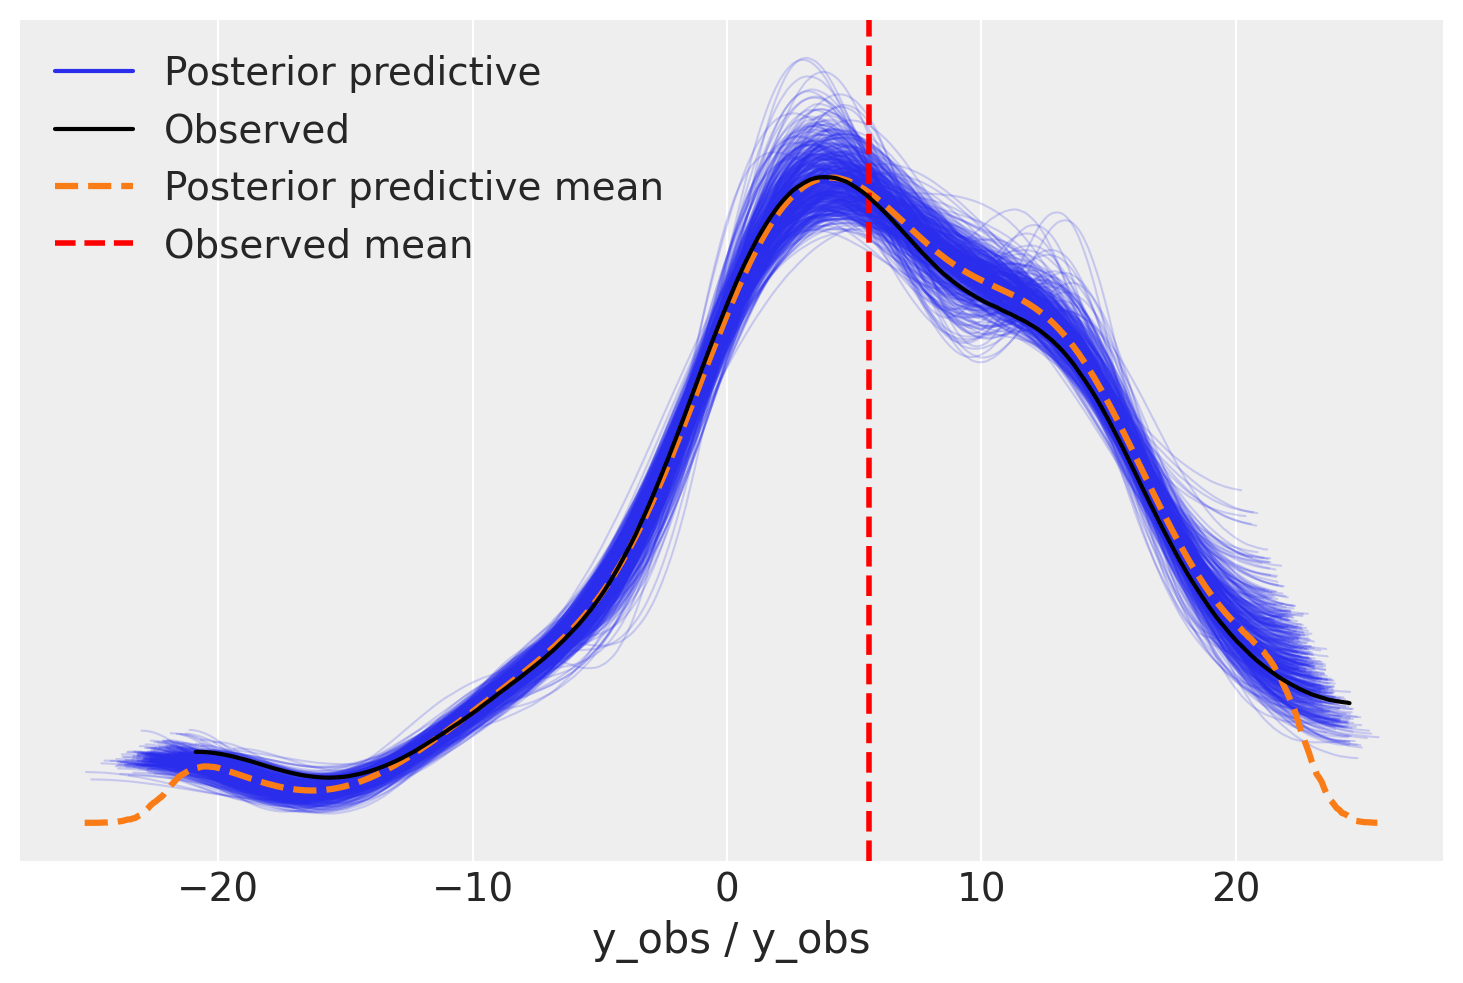

In [15]:
utils.plot_ppc(idata_emcee, y_obs=Y, n_samples=500, var_names=["y_obs"])

Combined autocorrelation times:


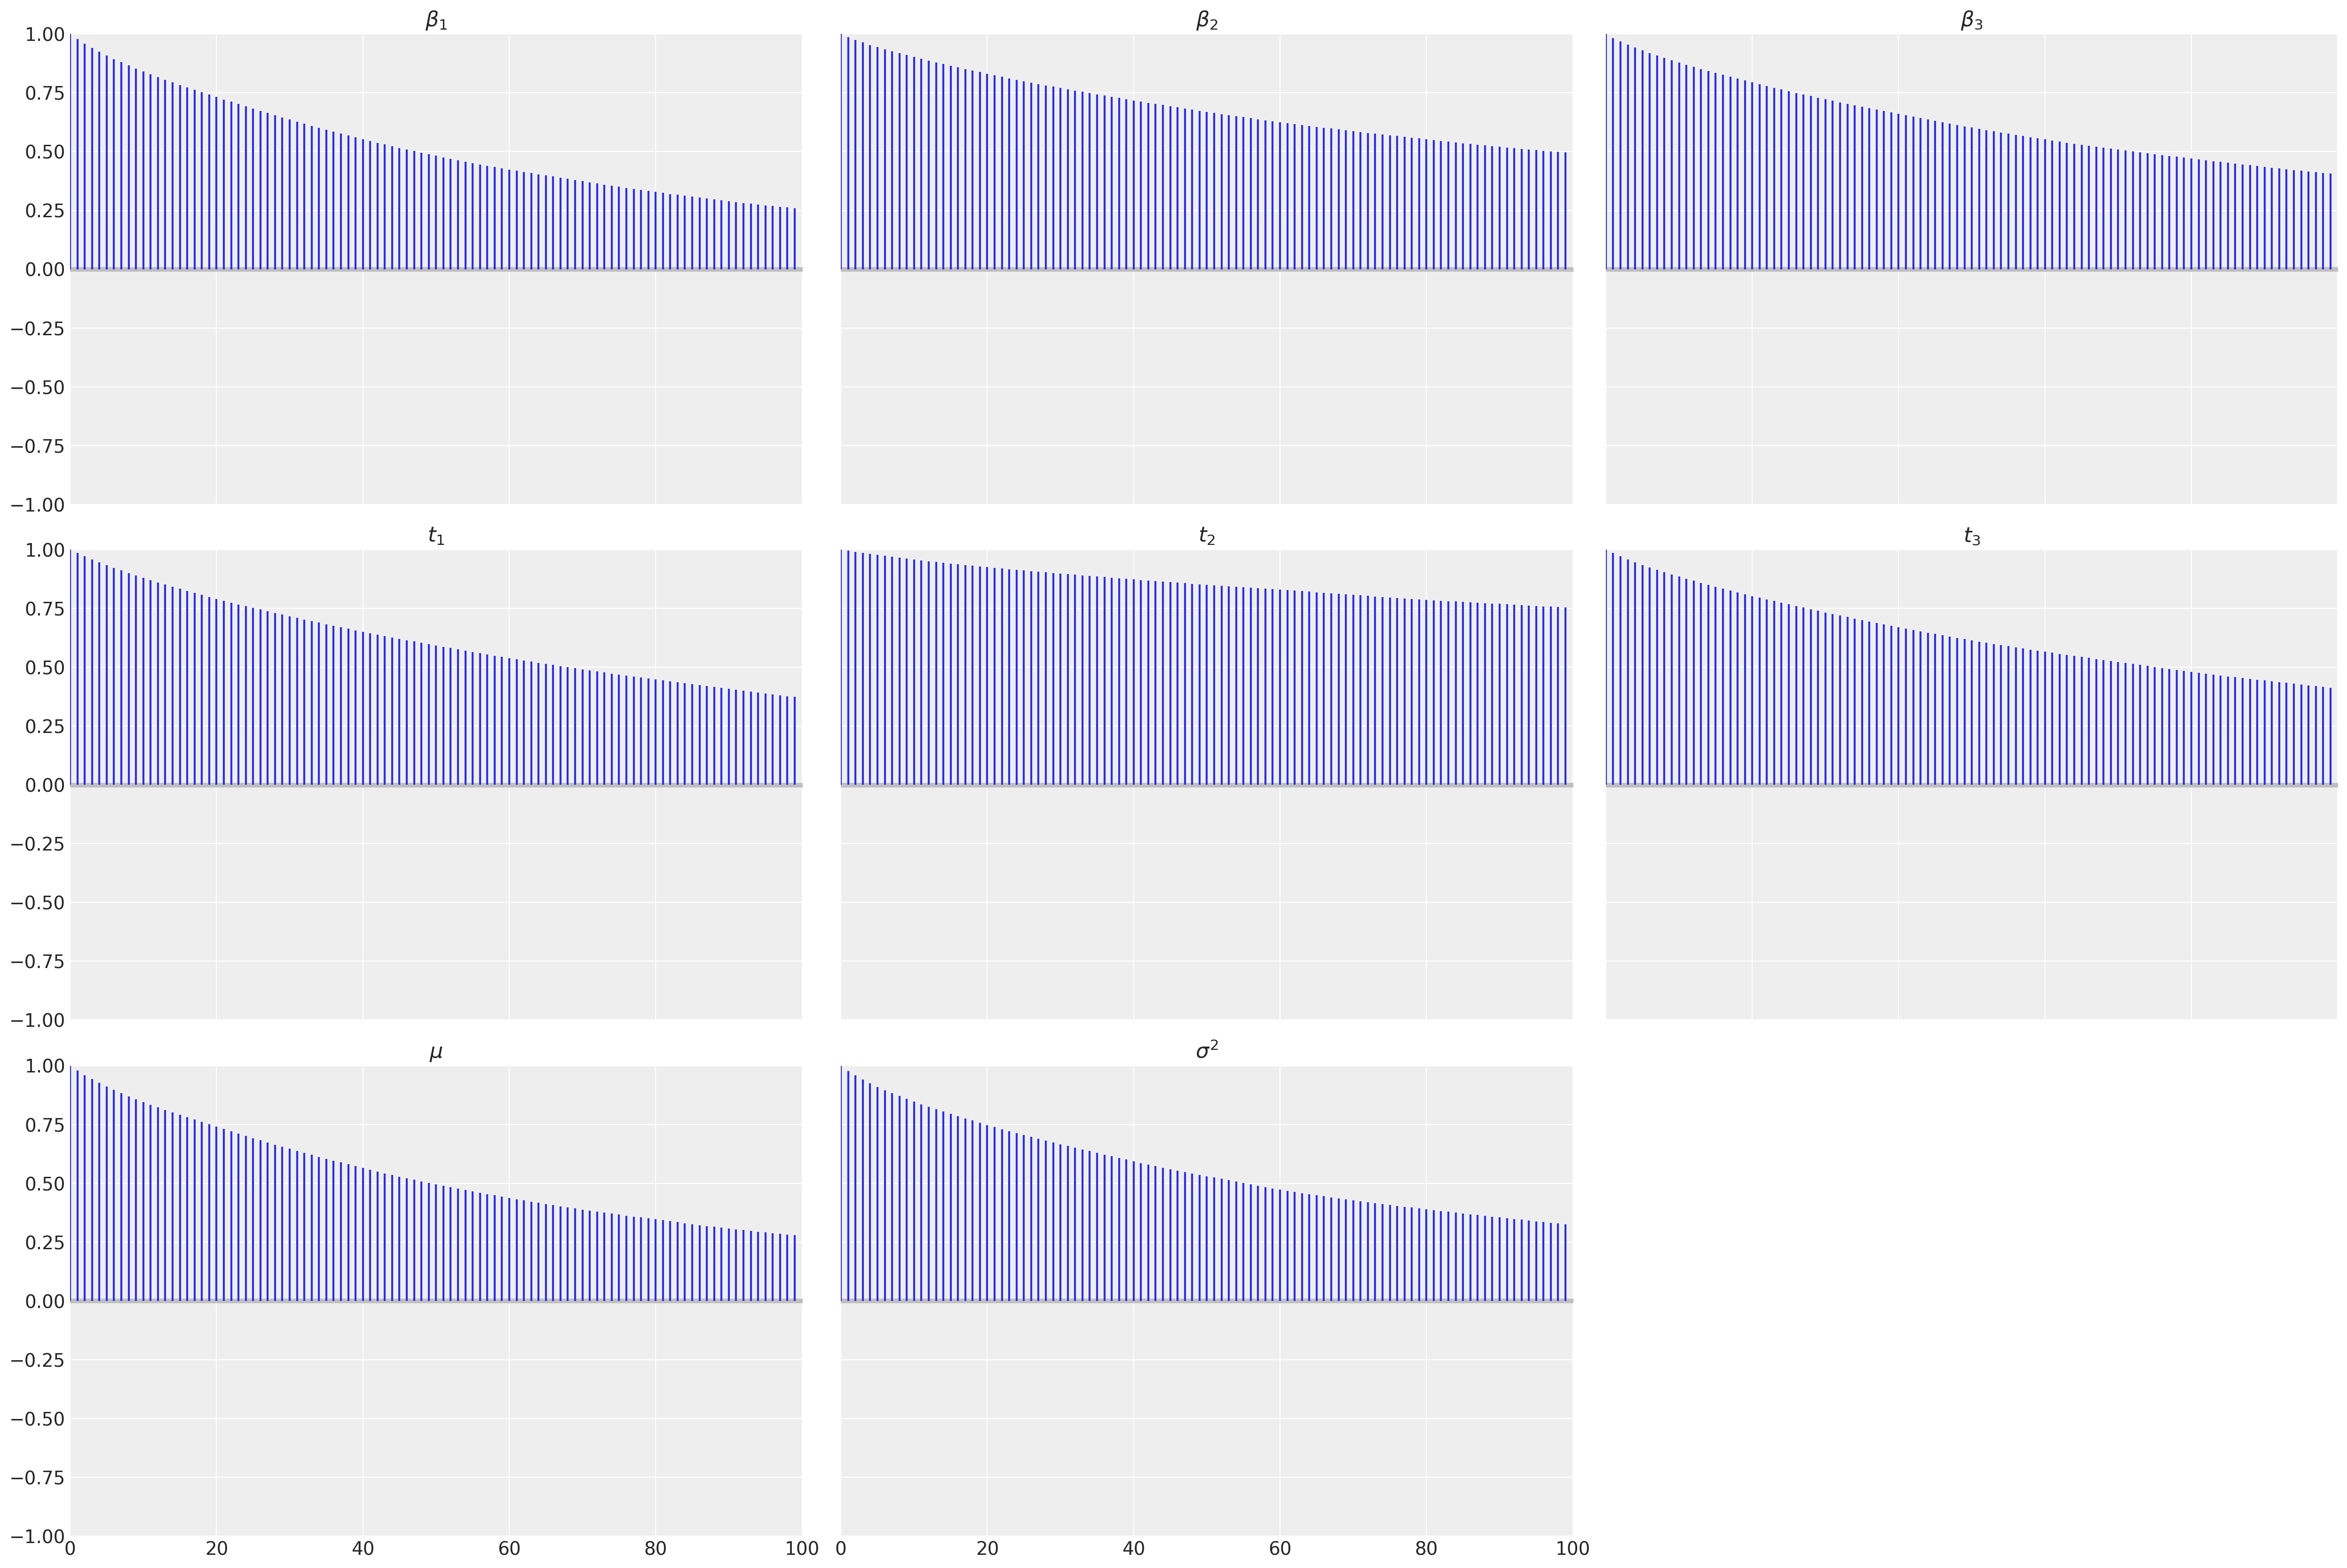

In [16]:
az.plot_autocorr(idata_emcee, combined=True, grid=(NROWS(theta_ndim), NCOLS))
print("Combined autocorrelation times:")

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [32]:
with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [37]:
with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [17]:
import pymc3 as pm
import theano
import theano.tensor as tt

In [18]:
# Labels for pymc
labeller = az.labels.MapLabeller(
    var_name_map={
        "beta": r"$\beta$",
        "tau": r"$\tau$",
        "mu": r"$\mu$",
        "sigma2": r"$\sigma^2$"}
)

### Model

We set the value of $b_0$ as the MLE for $\beta$.

In [19]:
def make_model(p, g, eta, X, Y, grid, init_MLE=True):
    if init_MLE:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed
        
    X_t = theano.shared(X)  # Transform X into Theano tensor

    with pm.Model() as model:
        mu_and_log_sigma = pm.DensityDist(
            'mu_and_log_sigma', lambda x: 0, shape=(2,))
        
        mu = pm.Deterministic('mu', mu_and_log_sigma[0])
        mus = mu*np.ones_like(Y)
        
        log_sigma = mu_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic('sigma2', sigma**2)

        tau = pm.Uniform('tau', 0.0, 1.0, shape=(p,))
        
        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_t[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist('beta', beta_lprior, shape=(p,))
        
        expected_obs = mus + pm.math.matrix_dot(X_tau, beta)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=Y)

    return model

### Experiments

In [20]:
# NUTS with MLE as starting point
model_MLE = make_model(p_hat, g, eta, X, Y, grid)

with model_MLE:
    print("Starting from MLE...")
    ttr = model_MLE.named_vars['tau'].transformation
    start = {"beta": mle_theta[:p_hat],
             "tau_interval__": ttr.forward(mle_theta[p_hat:2*p_hat]).eval(),
             "mu_and_log_sigma": mle_theta[-2:]}
    idata_mle = pm.sample(1000, cores=2, tune=1000, start=start,
                          target_accept=0.8, return_inferencedata=True)

Starting from MLE...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, tau, mu_and_log_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
utils.summary(idata_mle, theta_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  9.861  0.115   9.662   10.094      0.008    0.006     219.0   
beta[1] -4.231  0.348  -4.862   -3.563      0.023    0.016     230.0   
beta[2] -0.915  0.573  -2.001    0.166      0.033    0.024     303.0   
tau[0]   0.800  0.003   0.795    0.805      0.000    0.000     261.0   
tau[1]   0.100  0.003   0.096    0.105      0.000    0.000     357.0   
tau[2]   0.035  0.030   0.000    0.094      0.002    0.002     159.0   
mu       5.594  0.100   5.420    5.785      0.005    0.004     385.0   
sigma2   1.069  0.149   0.809    1.346      0.009    0.006     284.0   

         ess_tail  r_hat   mode  
beta[0]     282.0   1.02  9.851  
beta[1]     330.0   1.01 -4.330  
beta[2]     405.0   1.00 -0.575  
tau[0]      627.0   1.01  0.798  
tau[1]      857.0   1.00  0.104  
tau[2]      338.0   1.02  0.006  
mu          679.0   1.00  5.570  
sigma2      508.0   1.00  1.051

In [22]:
# NUTS with MAP as starting point
model_MAP = make_model(p_hat, g, eta, X, Y, grid)

with model_MAP:
    print("Computing MAP estimate...")
    start = pm.find_MAP()
    print("Starting from MAP estimate...")
    idata_map = pm.sample(1000, cores=2, tune=1000, start=start,
                          target_accept=0.8, return_inferencedata=True)

Computing MAP estimate...



Starting from MAP estimate...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, tau, mu_and_log_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
utils.summary(idata_map, theta_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  9.844  0.114   9.623   10.057      0.008    0.006     183.0   
beta[1] -4.170  0.385  -4.888   -3.450      0.029    0.020     191.0   
beta[2] -0.923  0.622  -2.122    0.265      0.036    0.026     291.0   
tau[0]   0.800  0.003   0.796    0.805      0.000    0.000     237.0   
tau[1]   0.100  0.003   0.095    0.104      0.000    0.000     285.0   
tau[2]   0.040  0.035   0.000    0.105      0.002    0.002     201.0   
mu       5.590  0.105   5.397    5.791      0.007    0.005     260.0   
sigma2   1.059  0.148   0.777    1.330      0.009    0.006     269.0   

         ess_tail  r_hat   mode  
beta[0]     275.0   1.01  9.864  
beta[1]     205.0   1.00 -4.228  
beta[2]     427.0   1.01 -1.036  
tau[0]      634.0   1.02  0.796  
tau[1]      630.0   1.00  0.100  
tau[2]      351.0   1.01  0.009  
mu          315.0   1.00  5.595  
sigma2      460.0   1.01  1.061

In [24]:
# NUTS with auto initialization
model_auto = make_model(p_hat, g, eta, X, Y, grid)

with model_auto:
    idata_auto = pm.sample(1000, cores=2, tune=1000, target_accept=0.8,
                           return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, tau, mu_and_log_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
utils.summary(idata_auto, theta_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  9.853  0.112   9.646   10.070      0.007    0.005     240.0   
beta[1] -4.159  0.408  -4.817   -3.277      0.036    0.025     147.0   
beta[2] -0.935  0.606  -2.032    0.187      0.041    0.031     236.0   
tau[0]   0.800  0.003   0.795    0.805      0.000    0.000     256.0   
tau[1]   0.100  0.003   0.095    0.105      0.000    0.000     294.0   
tau[2]   0.041  0.034   0.000    0.100      0.003    0.002     108.0   
mu       5.594  0.101   5.408    5.785      0.006    0.004     271.0   
sigma2   1.052  0.160   0.784    1.345      0.011    0.008     194.0   

         ess_tail  r_hat   mode  
beta[0]     381.0   1.01  9.854  
beta[1]     138.0   1.02 -4.302  
beta[2]     323.0   1.02 -0.959  
tau[0]      719.0   1.02  0.795  
tau[1]      813.0   1.00  0.095  
tau[2]      199.0   1.02  0.000  
mu          457.0   1.02  5.614  
sigma2      437.0   1.02  1.067

### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

Graphical model:


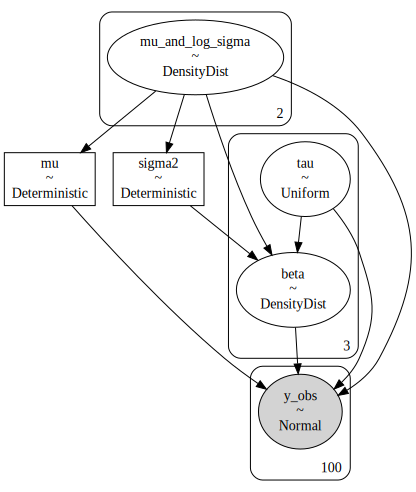

In [26]:
# Select and print best model
burn = 0
thin = 1

model = model_auto
idata_pymc = idata_auto
idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

Trace plot:


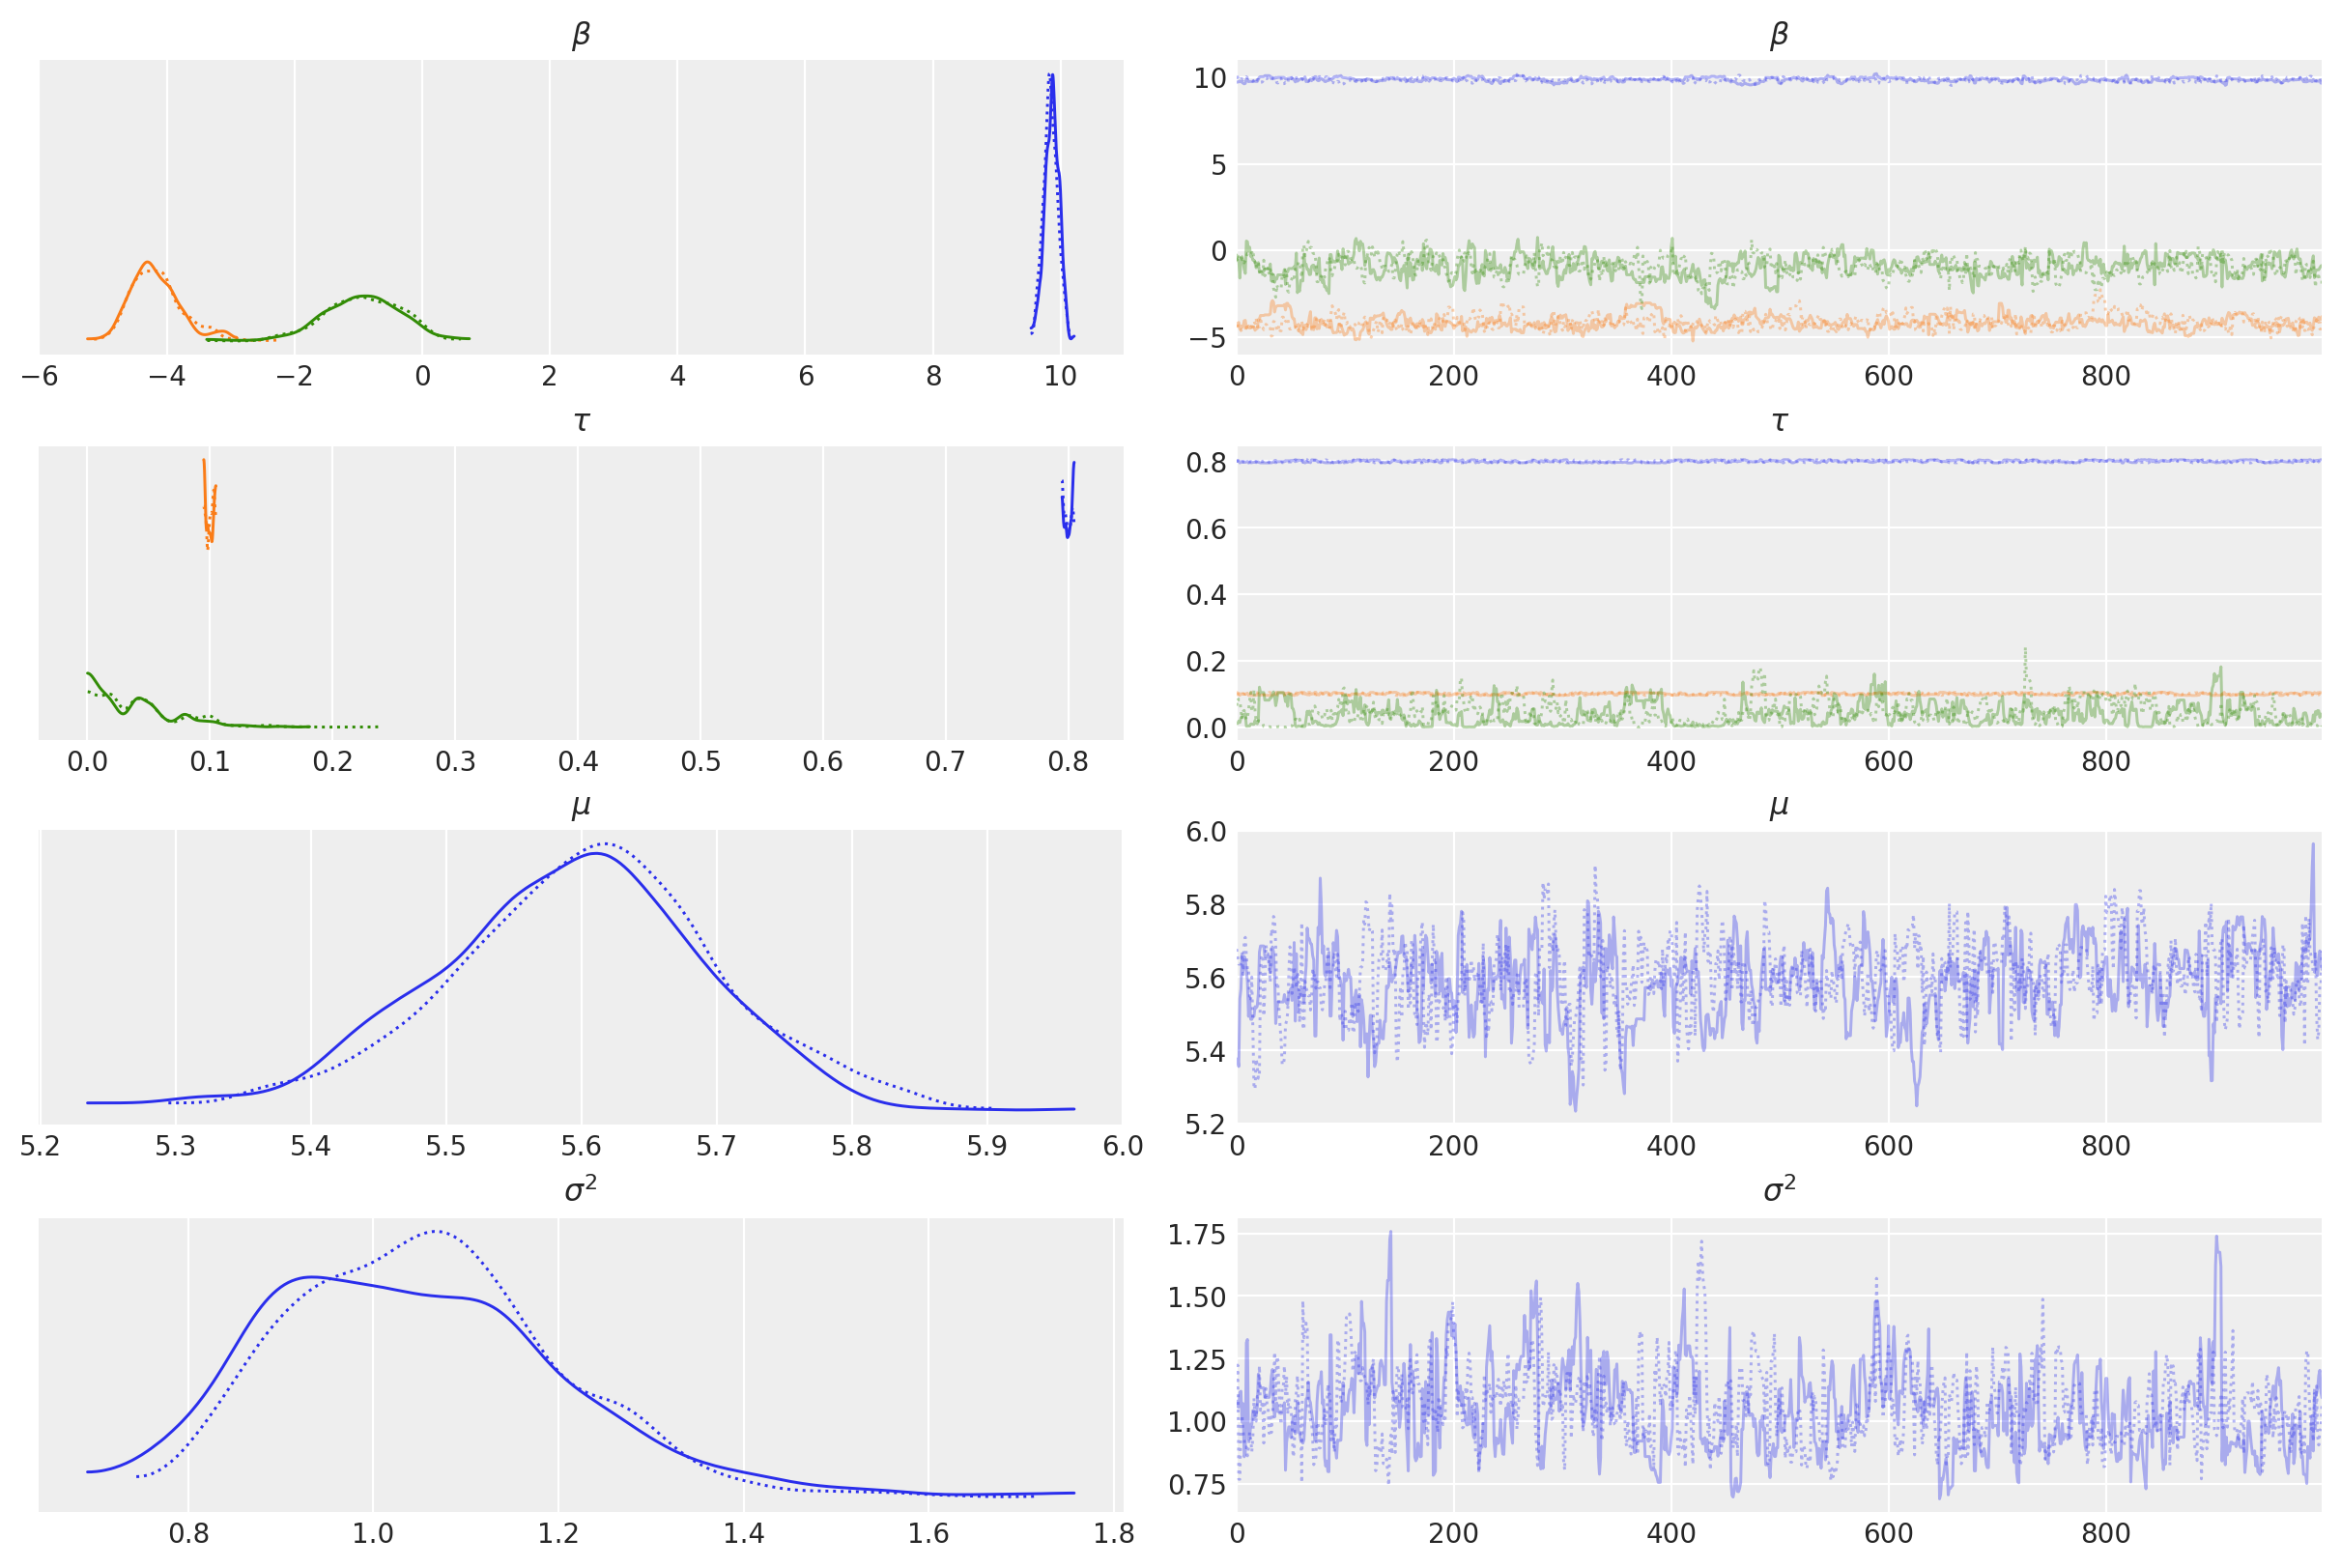

In [27]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=labeller)
print("Trace plot:")

Marginal posterior distributions:


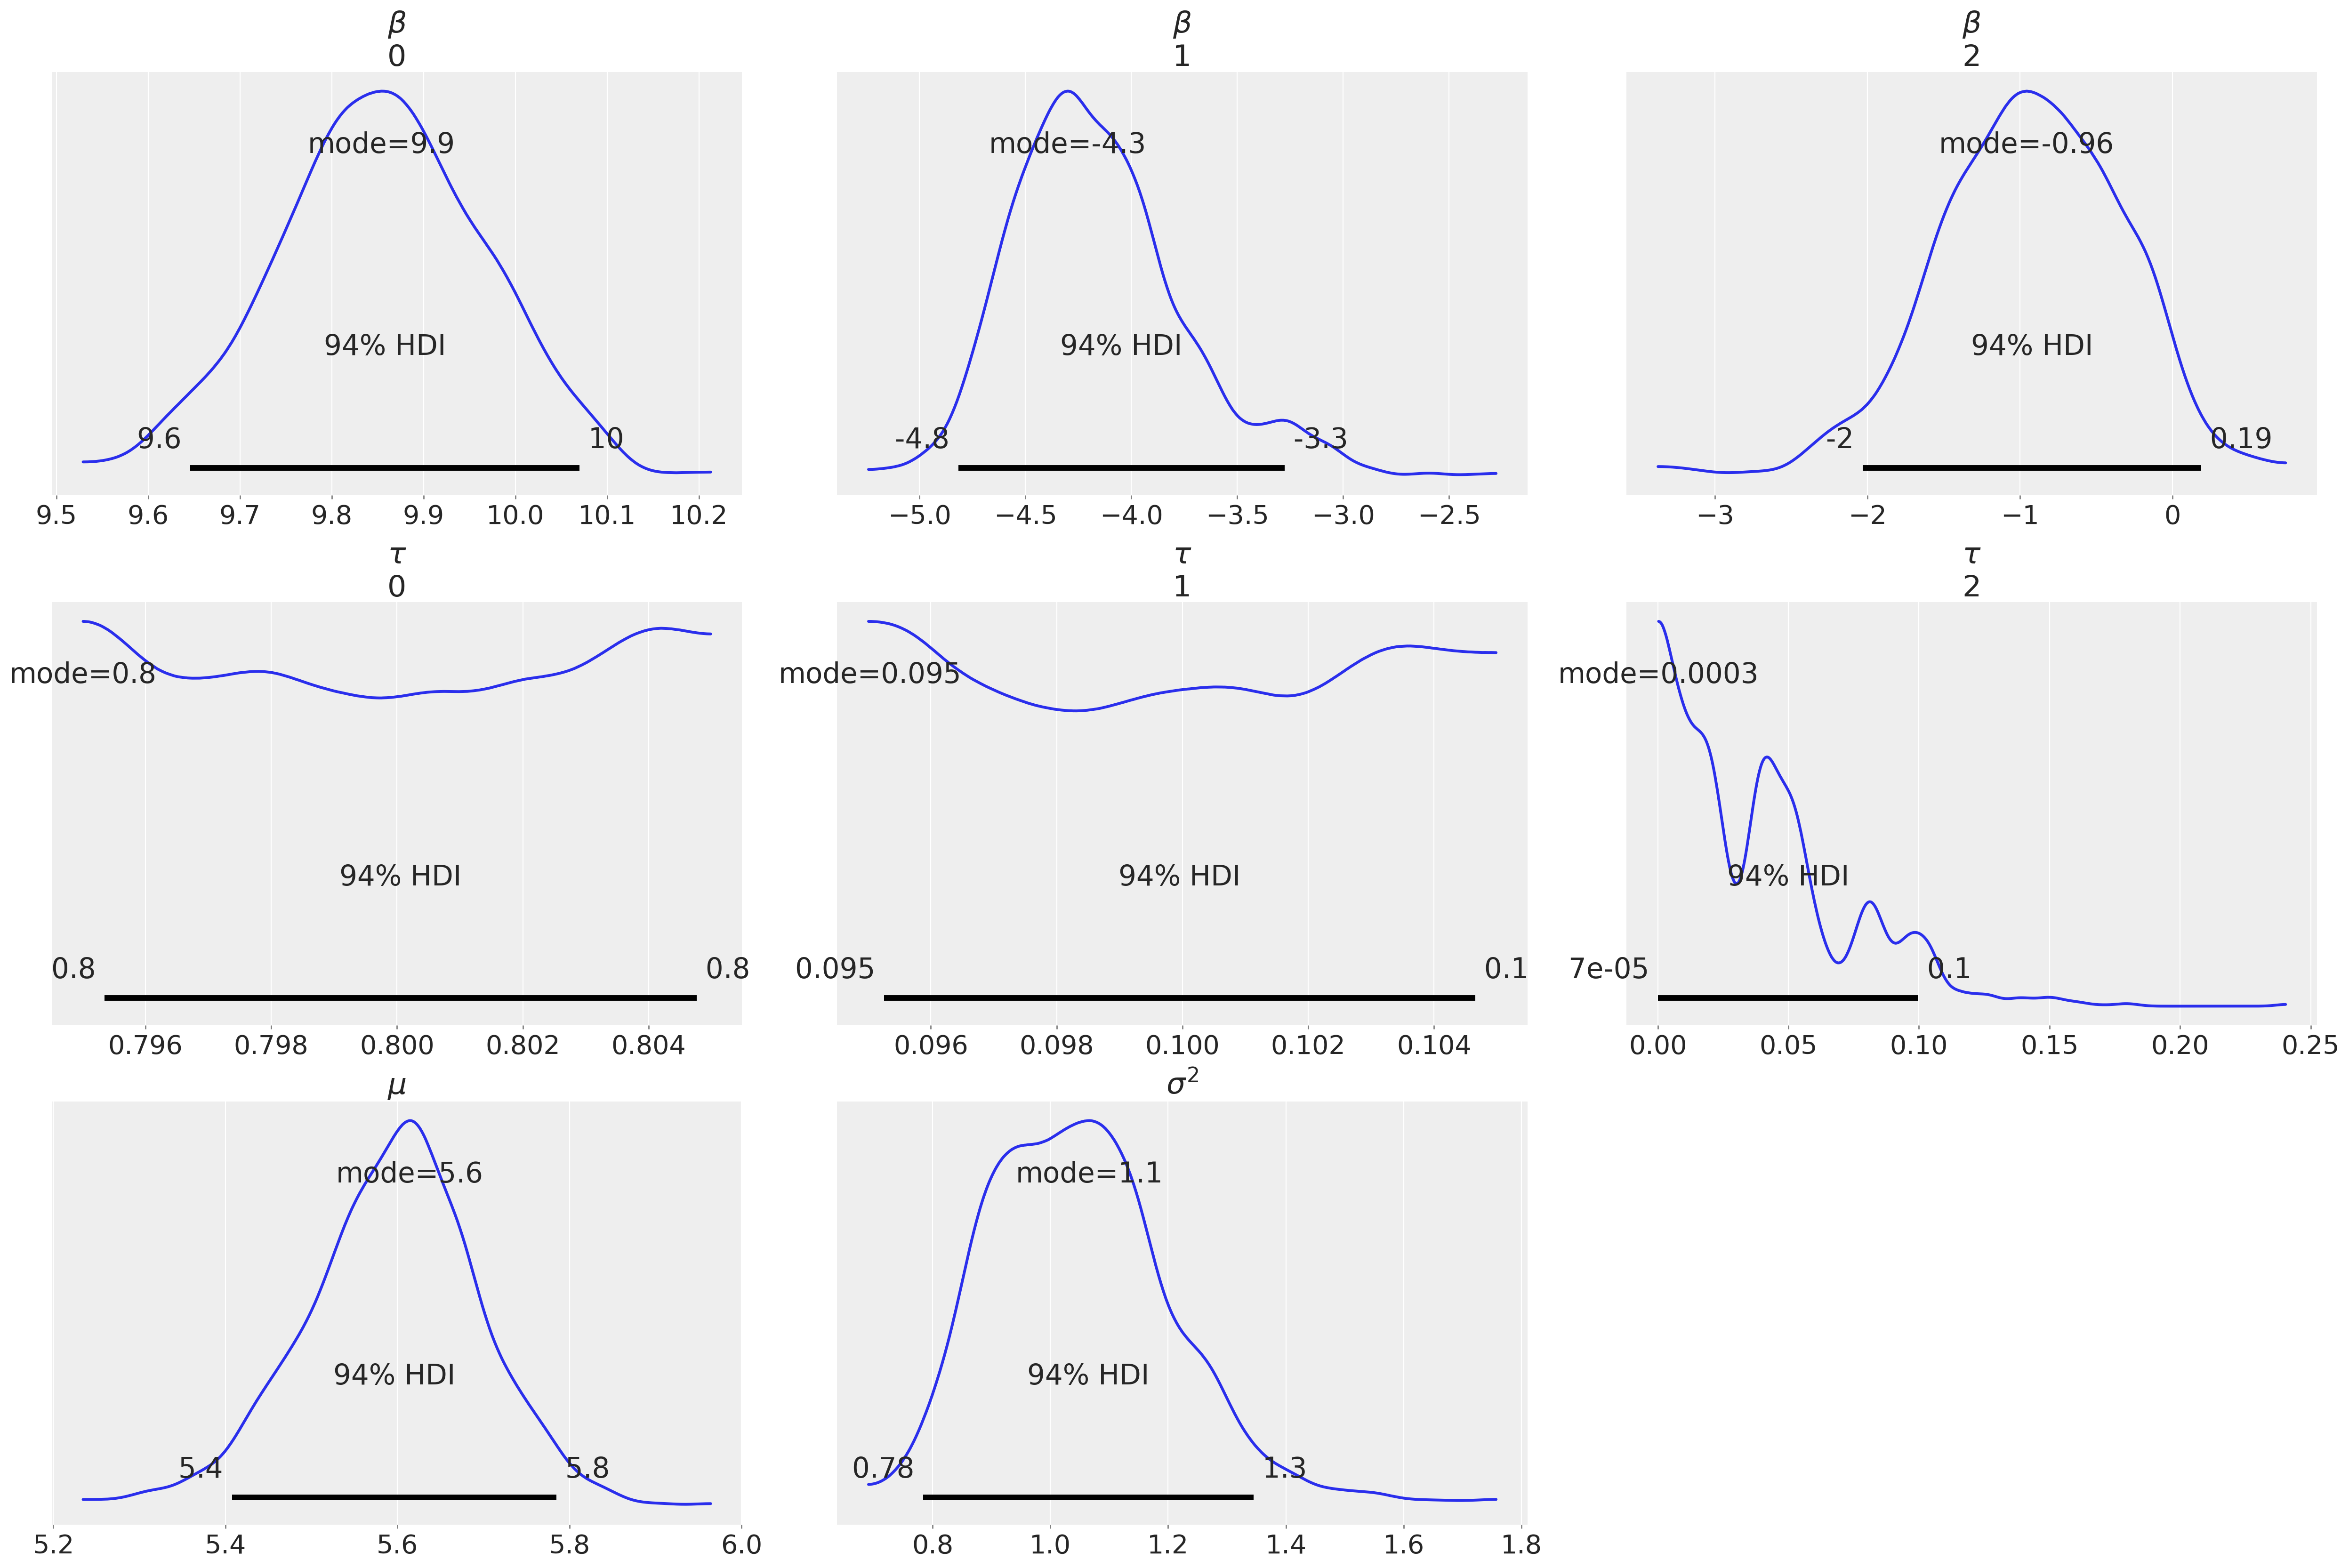

In [28]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


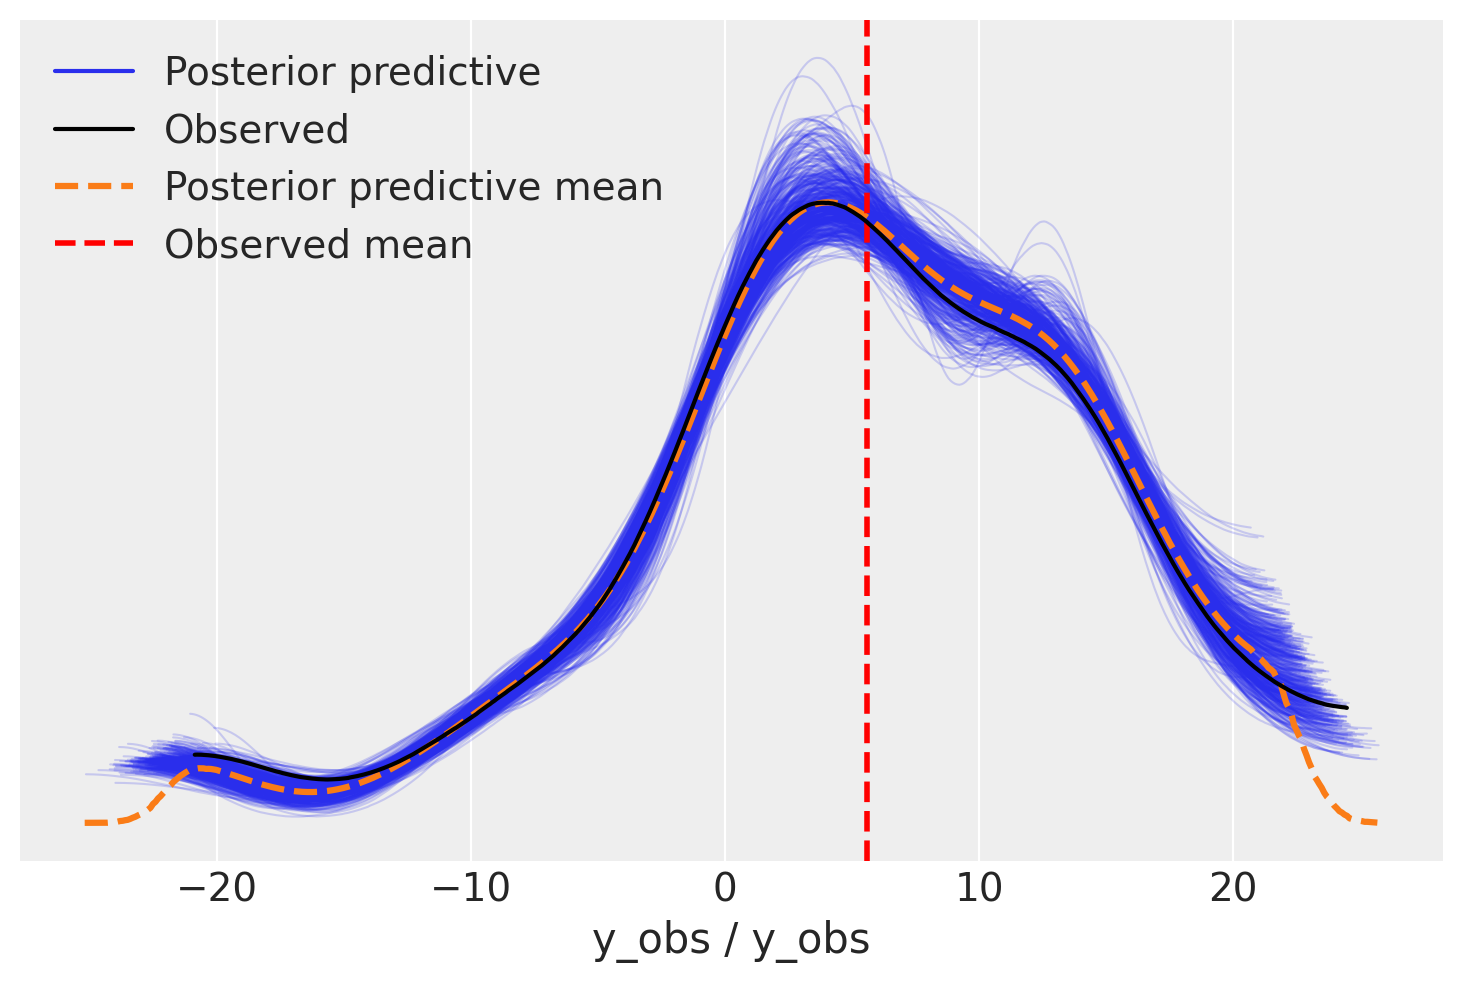

In [29]:
with model:
    print("Generating posterior predictive samples...")
    ppc = pm.sample_posterior_predictive(idata_pymc, var_names=["y_obs"])
    
utils.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc, model=model),
    y_obs=Y, n_samples=500, var_names=["y_obs"])

Combined autocorrelation times:


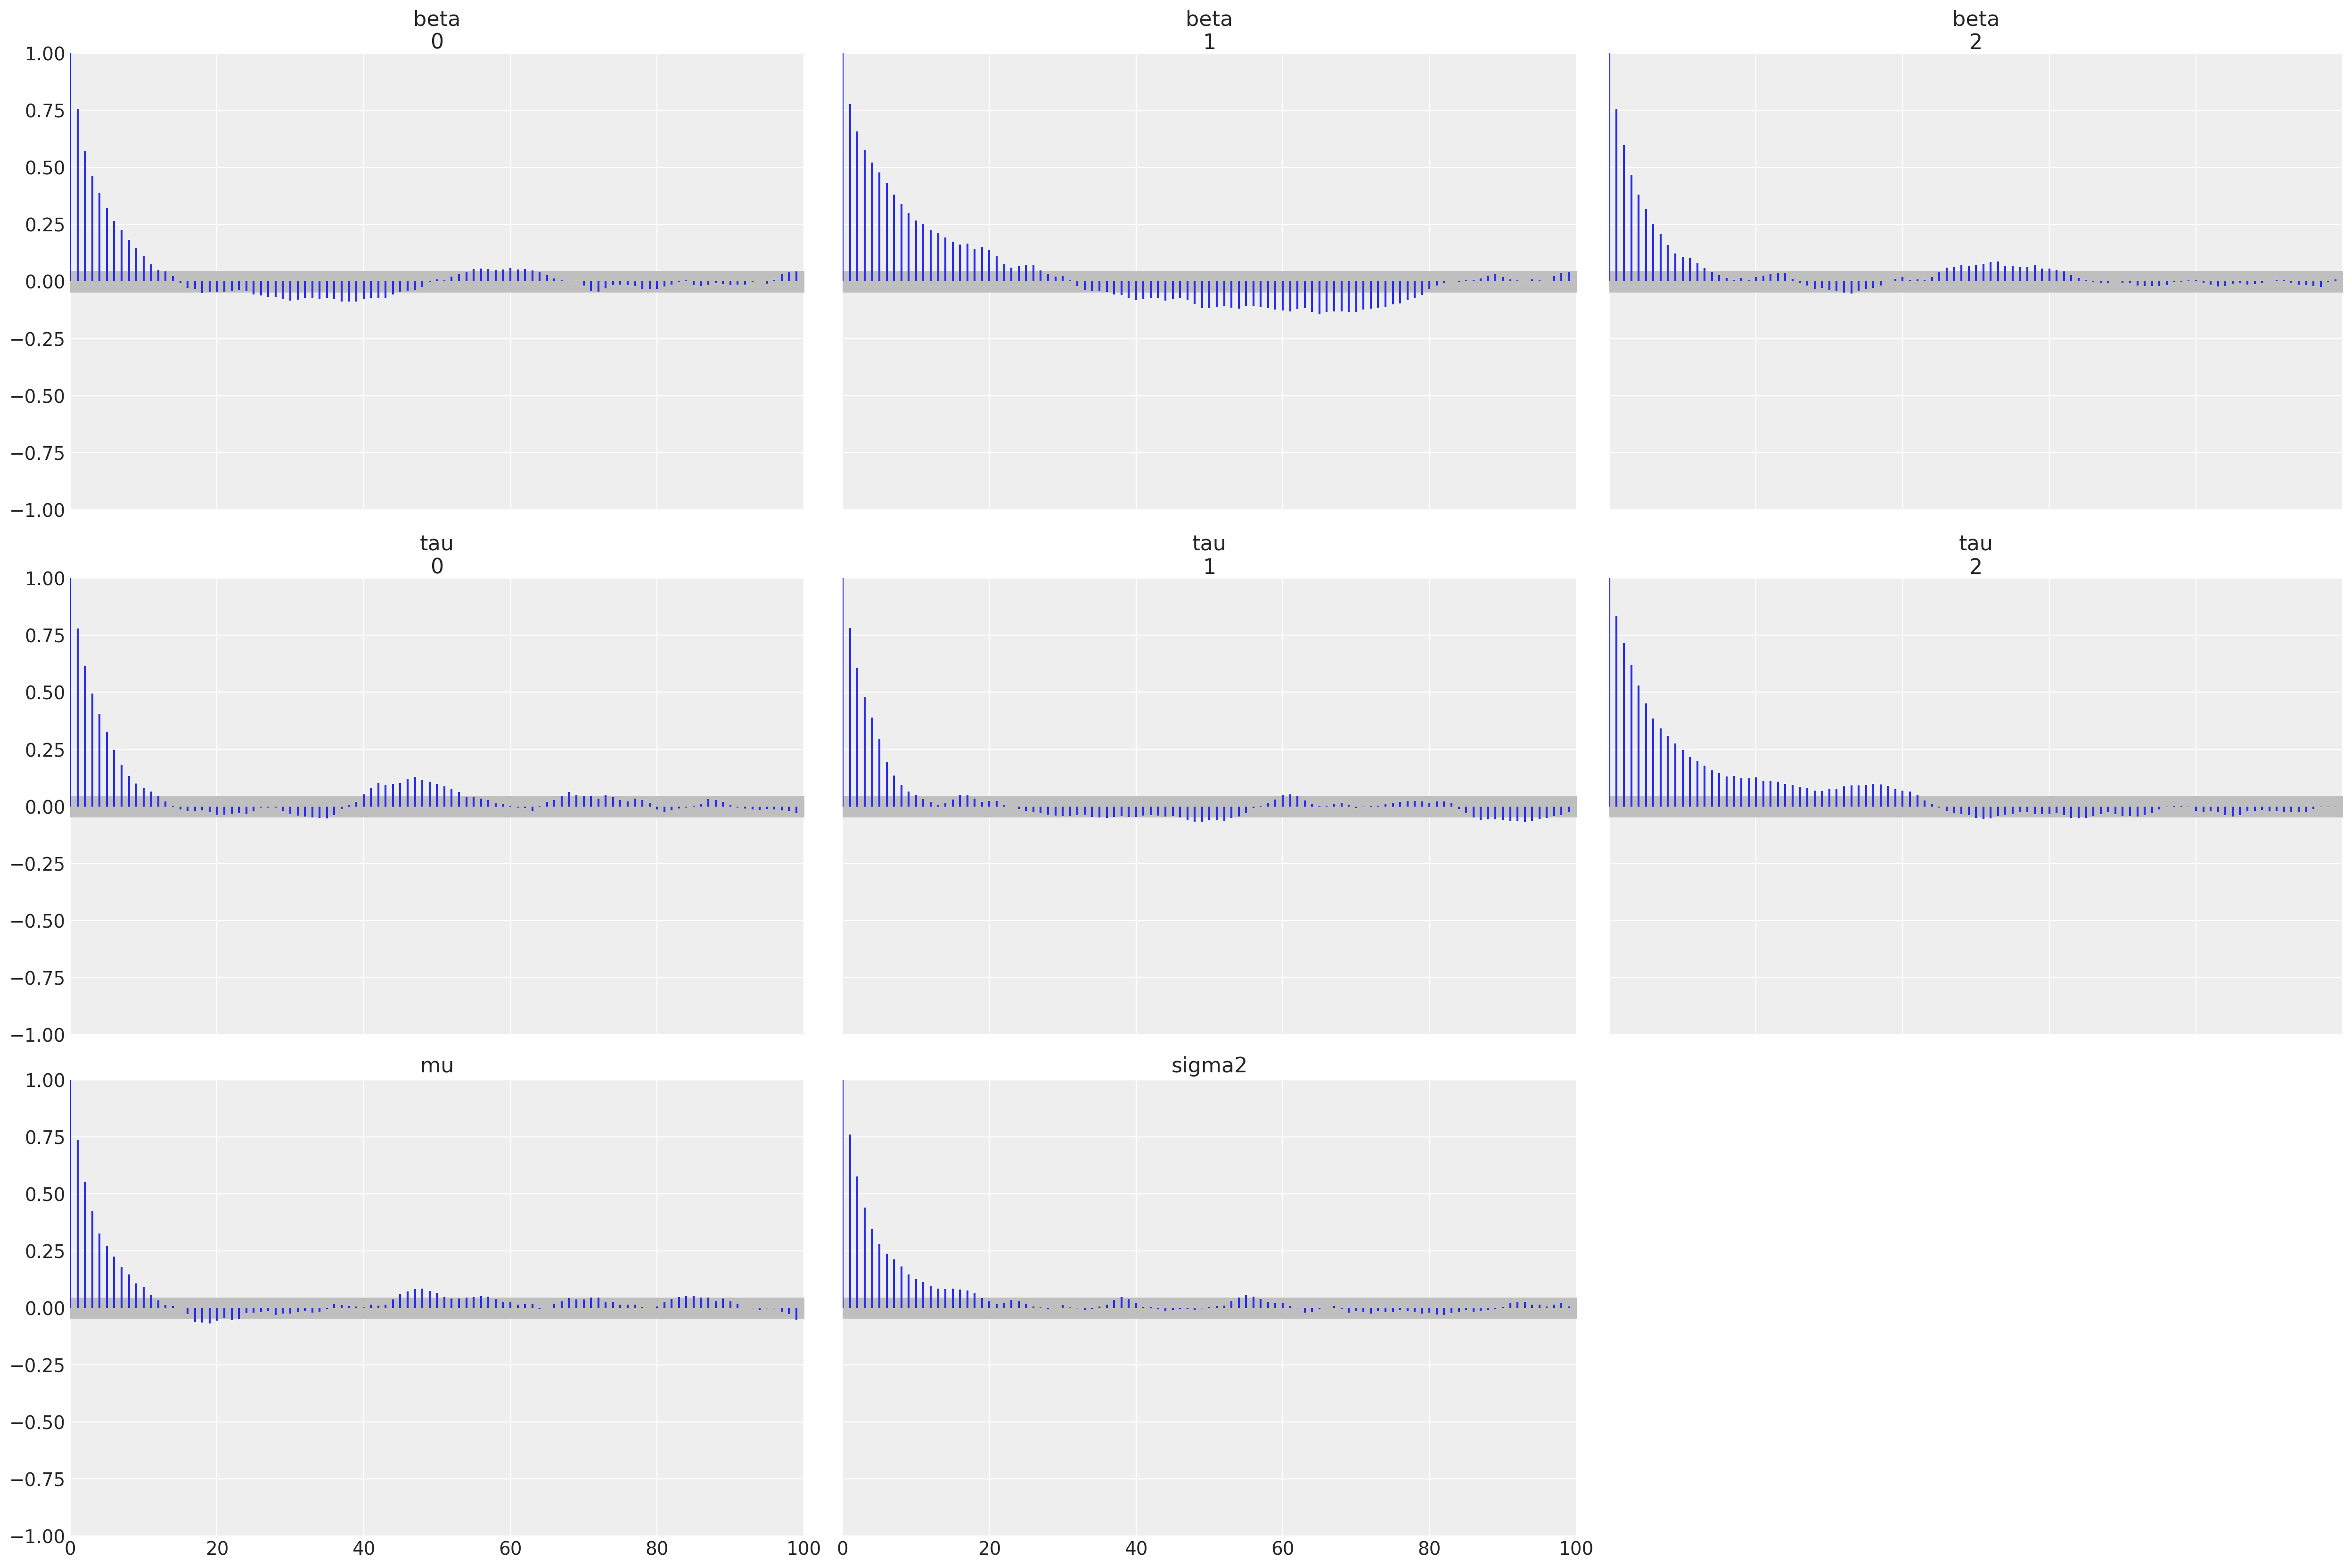

In [30]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS))
print("Combined autocorrelation times:")

### Save & Load

In [31]:
_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [34]:
idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notes

### Utility functions

- `az.plot_pairs`
- `corner.corner`

### Alternative samplers in PyMC3

- `Metropolis` (+ MLE, MAP)
- `DeMetropolis(Z)`
- `Variational Inference in PyMC3`

### Alternative samplers in emcee

- Try different move proposals, or even a weighted mixture of moves.

### What's new in pymc v4

Some differences in the new release (see RELEASE-NOTES):

- Can pass distribution arguments (i.e RVs) to DensityDist. It has a new API.
- Model() accepts an `rng_seeder` argument to set the random seed.
- sample_posterior_predictive now returns an InferenceData object directly.
- shape vs ndim arguments in Distributions?

## Notebook metadata

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Oct 22 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

matplotlib: 3.4.3
json      : 2.0.9
pandas    : 1.3.3
arviz     : 0.11.4
scipy     : 1.7.1
emcee     : 3.1.1
numpy     : 1.21.2
autopep8  : 1.5.7

Watermark: 2.2.0

